What this notebook does:

Assigns sentiment to topics for all sentences, for all coffee shop reviews. For each sentence, topic importance and vader compound sentiment S are measured. If for topic X, the topic importance is greater than 0.2, the sentiment Sxtopic_importance is assigned to topic X for that sentence.

Topic importance scores for each sentence come from the 5-topic LDA model fitted on the nouns of each review ('./LDA_Fitting/LDA_onreviews_nouns_withhyptuning.ipynb')

The resulting feature matrix is saved in './ProcessedData/reviewsent_sentiment_thresh0.2soft.csv'. These topic/sentence specific sentiments will be averaged within each review in './LDA_5topic_SentimentAssignment/EngineeringFeatures_basedon_5LDAnountopics.ipynb'

In [ ]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

In [1]:
import random

import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
#import en_core_web_sm

from tqdm import tqdm_notebook as tqdm
from pprint import pprint

from helper_functions.lda_application_helpers import getldavec, sentencebasedsentiment
import pickle
from gensim.test.utils import datapath
from gensim.models import LdaModel
from gensim import corpora

import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.id2word thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.id2word

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.state thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.state

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.expElogbeta.npy thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim.expElogbeta.npy

cp thomasyoung/opt/anaconda3/envs/nlp_env/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim thomasyoung/opt/anaconda3/envs/nlp_envp3/lib/python3.6/site-packages/gensim/test/test_data/lda_nounsonly_5topics.gensim               

In [31]:
sentdf = pd.read_csv('./ProcessedData/reviewsentences_lemmatized.csv')
print(sentdf.shape)

#Only use a subset of 8000 reviews to compare different thresholds
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./ProcessedData/lemmatizedreviews.csv')
reviews.rename(columns = {'rating':'review_rating'},inplace=True)
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])

#dropnan
sentdf = sentdf.dropna(axis=0)
print(sentdf.shape)

#rest index
sentdf.reset_index(inplace=True, drop = True)

(244523, 3)
(244381, 3)


In [32]:
#Loading the previously trained LDA model

dictionary = gensim.corpora.Dictionary.load('dictionary_allreviews_nouns.gensim')
corpus = pickle.load(open('corpus_allreviews_nouns.pkl', 'rb'))

temp_file = datapath("lda_nounsonly_5topics.gensim")
lda = gensim.models.ldamodel.LdaModel.load(temp_file)


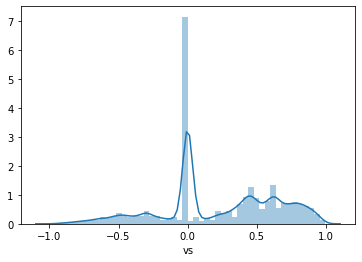

In [33]:
#Vader Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

#Getting sentiments
vs = [analyzer.polarity_scores(sentence)['compound'] for sentence in sentdf.sentence]
sentdf['vs'] = pd.Series(vs)
sns.distplot(sentdf['vs'])

In [18]:
ldavecs = getldavec(sentdf.lemsentence.tolist(),dictionary,lda)
ldavdf = pd.DataFrame(ldavecs,columns = ['t0','t1','t2','t3','t4'])
ldavdf.head(10)

,t0,t1,t2,t3,t4
0,0.082959,0.087602,0.666566,0.081756,0.081116
1,0.171693,0.441144,0.338163,0.024445,0.024556
2,0.050149,0.551541,0.050151,0.298008,0.050151
3,0.067680,0.067871,0.399465,0.066672,0.398313
4,0.100198,0.100198,0.100202,0.599202,0.100200
5,0.554707,0.047900,0.301966,0.047682,0.047745
6,0.031821,0.031826,0.516953,0.202905,0.216495
7,0.022466,0.739682,0.192984,0.022482,0.022387
8,0.897584,0.026126,0.025270,0.025388,0.025631
9,0.296633,0.247997,0.260805,0.130790,0.063775


In [21]:
print(ldavdf[ldavdf.isnull().any(axis=1)].shape)
print(ldavdf.shape)

(1263, 5)
(244381, 5)


In [22]:

results = sentencebasedsentiment(vs,ldavecs,threshold = 0.2,soft=True)


In [24]:
#lda_sent_pt5_soft[0:10]
print(len(results))
print(len(sentdf))

244381
244381


In [34]:
#Need to group the sentence results together to get a sentiment score at the review level
#Then need to save the results to the data frame so they can further be analyzed

newdf = pd.DataFrame(results)
newdf.columns = ['t' + str(i) + 's' for i in range(5)]
sentdf.reset_index(inplace=True,drop=True)
sentdf = pd.concat([sentdf,newdf],axis=1)



In [37]:
sentdf.to_csv('./ProcessedData/reviewsent_sentiment_thresh0.2soft.csv',index=False)